In [11]:
import os

import numpy as np
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from utils import CSVDrugResponseDataset

assert pyro.__version__.startswith('1.9.1')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

In [12]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):

    data_dir = "../dataset/Cancer"
    training_dataset = CSVDrugResponseDataset(data_dir, "training")
    train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory = use_cuda)

    testing_dataset = CSVDrugResponseDataset(data_dir, "testing")
    test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory = use_cuda)
    return train_loader, test_loader

In [13]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 5056)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 5056
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [14]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(5056, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 5056)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [15]:
# define the model p(x|z)p(z)
def model(self, x):
    # register PyTorch module `decoder` with Pyro
    pyro.module("decoder", self.decoder)
    with pyro.plate("data", x.shape[0]):
        # setup hyperparameters for prior p(z)
        z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
        z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
        # decode the latent code z
        loc_img = self.decoder(z)
        # score against actual images
        pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 5056))

In [16]:
# define the guide (i.e. variational distribution) q(z|x)
def guide(self, x):
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.encoder)
    with pyro.plate("data", x.shape[0]):
        # use the encoder to get the parameters used to define q(z|x)
        z_loc, z_scale = self.encoder(x)
        # sample the latent code z
        pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))


In [17]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 5056))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [18]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train


In [19]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test


In [21]:
    # Run options
    LEARNING_RATE = 1.0e-3
    USE_CUDA = True

    # Run only for a single iteration for testing
    NUM_EPOCHS = 100
    TEST_FREQUENCY = 5

    train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

    # clear param store
    pyro.clear_param_store()

    # setup the VAE
    vae = VAE(use_cuda=USE_CUDA)

    # setup the optimizer
    adam_args = {"lr": LEARNING_RATE}
    optimizer = Adam(adam_args)

    # setup the inference algorithm
    svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

    train_elbo = []
    test_elbo = []
    # training loop
    for epoch in range(NUM_EPOCHS):
        total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
        train_elbo.append(-total_epoch_loss_train)
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

        if epoch % TEST_FREQUENCY == 0:
            # report test diagnostics
            total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
            test_elbo.append(-total_epoch_loss_test)
            print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 1044.2808
[epoch 000] average test loss: 785.6331
[epoch 001]  average training loss: 774.4015
[epoch 002]  average training loss: 753.6362
[epoch 003]  average training loss: 748.0901
[epoch 004]  average training loss: 746.9161
[epoch 005]  average training loss: 746.4251
[epoch 005] average test loss: 749.6040
[epoch 006]  average training loss: 745.7293
[epoch 007]  average training loss: 745.1288
[epoch 008]  average training loss: 743.7616
[epoch 009]  average training loss: 741.1719
[epoch 010]  average training loss: 736.6921
[epoch 010] average test loss: 737.8558
[epoch 011]  average training loss: 730.7666
[epoch 012]  average training loss: 725.1758
[epoch 013]  average training loss: 719.8898
[epoch 014]  average training loss: 713.7906
[epoch 015]  average training loss: 706.3354
[epoch 015] average test loss: 708.9965
[epoch 016]  average training loss: 696.2101
[epoch 017]  average training loss: 684.1534
[epoch 018]  average training

In [2]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get current CUDA device
    device = torch.cuda.current_device()

    # Get the name of the device
    print(f"CUDA Device: {torch.cuda.get_device_name(device)}")

    # Check memory usage (in bytes)
    total_memory = torch.cuda.get_device_properties(device).total_memory
    reserved_memory = torch.cuda.memory_reserved(device)
    allocated_memory = torch.cuda.memory_allocated(device)
    free_memory = total_memory - reserved_memory

    print(f"Total Memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Reserved Memory: {reserved_memory / (1024 ** 3):.2f} GB")
    print(f"Allocated Memory: {allocated_memory / (1024 ** 3):.2f} GB")
    print(f"Free Memory: {free_memory / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available.")


CUDA Device: NVIDIA A100-PCIE-40GB
Total Memory: 39.49 GB
Reserved Memory: 0.00 GB
Allocated Memory: 0.00 GB
Free Memory: 39.49 GB


In [1]:
import torch
print(torch.version.cuda)


12.4


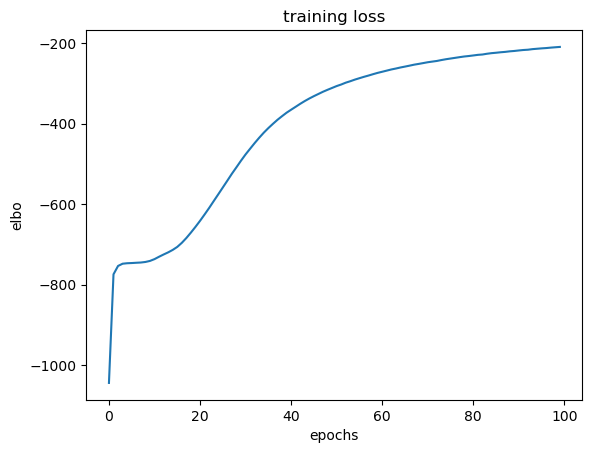

In [31]:
import matplotlib.pyplot as plt
plt.plot(train_elbo)
plt.xlabel("epochs")
plt.ylabel("elbo")
plt.title("training loss")
plt.show()

In [24]:
import torch
import pyro.distributions as dist

def get_latent_representations(vae, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    vae.eval()  # Set the model to evaluation mode
    latents = []
    labels = []
    
    with torch.no_grad():  # No need to compute gradients
        for x, y in dataloader:  # Assuming (data, labels) from dataloader
            x = x.to(device)
            z_loc, z_scale = vae.encoder(x)  # Get latent distribution parameters
            z = dist.Normal(z_loc, z_scale).sample()  # Sample latent variable
            latents.append(z)
            labels.append(y)
    
    return torch.cat(latents, dim=0), torch.cat(labels, dim=0)

In [25]:
latents, labels = get_latent_representations(vae, train_loader)

/home/leo/miniforge3/envs/hdp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


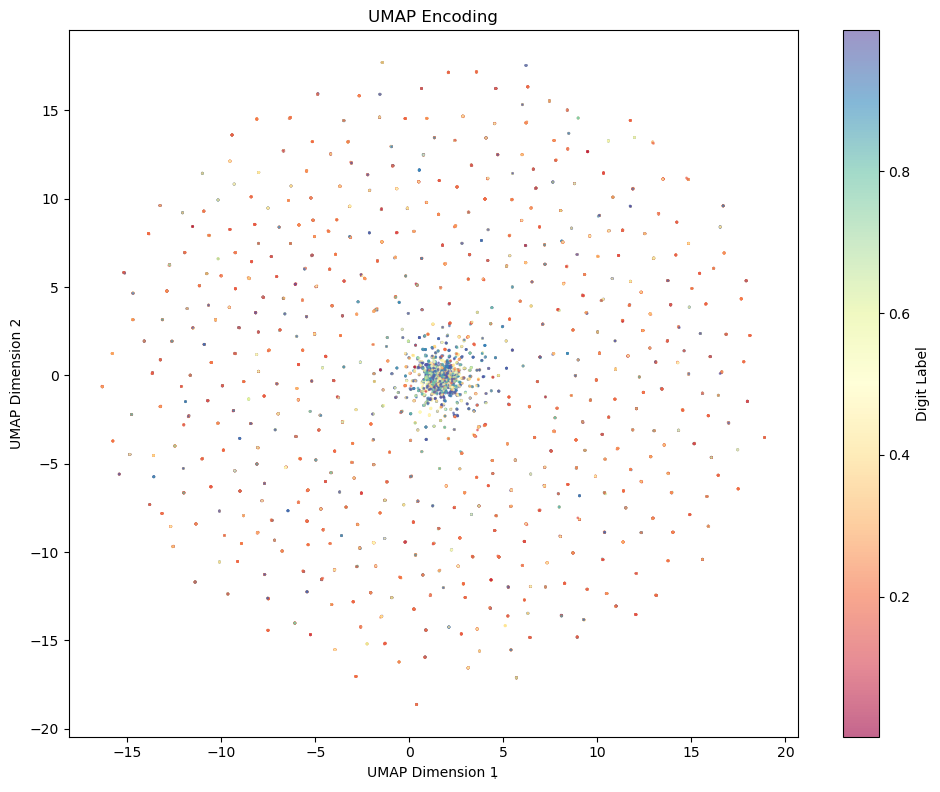

In [28]:
from utils import visualize_data_from_tensor

visualize_data_from_tensor(latents, labels, ".", True)